In [28]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Folder paths
folder_path = r"B:\ml modeling project course\lessfiles"
folder_pathout = r"B:\ml modeling project course"
model_output_dir = os.path.join(folder_pathout, "trained_models")

# Ensure model output directory exists
os.makedirs(model_output_dir, exist_ok=True)

# Features and target columns
features = ["Year", "Month", "Day", "Latitude", "Longitude", "sm_surface_model", "sm_rootzone_model"]
targets = ["sm_surface", "sm_rootzone"]

# List to store results
results = []

# Iterate through each file in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        # Extract latitude and longitude from the filename
        base_name = os.path.splitext(file)[0]  # Remove .csv extension
        try:
            lat, lon = map(float, base_name.split('_')[1:3])
        except (ValueError, IndexError) as e:
            print(f"Skipping {file} - invalid filename format: {str(e)}")
            continue
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(folder_path, file))
        
        # Feature engineering
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['Latitude'] = lat
        df['Longitude'] = lon
        df = df.sort_values('Date').reset_index(drop=True)
        
        # Get sorted unique years (2016-2020)
        years = sorted(df['Year'].unique())
        if len(years) != 5:
            print(f"Skipping {file} - requires exactly 5 years of data")
            continue
            
        print(f"\nProcessing {file}")

        # Create 5 validation splits (4 train years + 1 test year)
        for i in range(len(years)):
            test_year = years[i]
            train_years = [years[j] for j in range(len(years)) if j != i]
            
            if len(train_years) != 4:
                raise ValueError("Training window must contain 4 years")
                
            train_mask = df['Year'].isin(train_years)
            test_mask = df['Year'] == test_year

            X_train, X_test = df.loc[train_mask, features], df.loc[test_mask, features]
            y_train, y_test = df.loc[train_mask, targets], df.loc[test_mask, targets]

            # Configure Random Forest Regressor
            model_random = RandomForestRegressor(
                n_estimators=500,
                max_depth=20,
                max_features="sqrt",
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            )
            
            # Train the model and make predictions
            model_random.fit(X_train, y_train)
            preds = model_random.predict(X_test)
            
            # Save the trained model
            model_filename = f"RF_{base_name}_test{test_year}.joblib"
            joblib.dump(model_random, os.path.join(model_output_dir, model_filename))
            print(f"Saved model: {model_filename}")



Processing SMAP_20.5132_75.015564.csv
Saved model: RF_SMAP_20.5132_75.015564_test2016.joblib
Saved model: RF_SMAP_20.5132_75.015564_test2017.joblib
Saved model: RF_SMAP_20.5132_75.015564_test2018.joblib
Saved model: RF_SMAP_20.5132_75.015564_test2019.joblib
Saved model: RF_SMAP_20.5132_75.015564_test2020.joblib

Processing SMAP_20.5132_75.108925.csv
Saved model: RF_SMAP_20.5132_75.108925_test2016.joblib
Saved model: RF_SMAP_20.5132_75.108925_test2017.joblib
Saved model: RF_SMAP_20.5132_75.108925_test2018.joblib
Saved model: RF_SMAP_20.5132_75.108925_test2019.joblib
Saved model: RF_SMAP_20.5132_75.108925_test2020.joblib

Processing SMAP_20.5132_75.202286.csv
Saved model: RF_SMAP_20.5132_75.202286_test2016.joblib
Saved model: RF_SMAP_20.5132_75.202286_test2017.joblib
Saved model: RF_SMAP_20.5132_75.202286_test2018.joblib
Saved model: RF_SMAP_20.5132_75.202286_test2019.joblib
Saved model: RF_SMAP_20.5132_75.202286_test2020.joblib

Processing SMAP_20.5132_75.29565.csv
Saved model: RF_SMAP

In [34]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#R2 calculation
def cal_r2(obs,pre):
  numerator = np.sum((obs - np.mean(obs)) * (pre - np.mean(pre)))
  denominator = np.sqrt(np.sum((obs - np.mean(obs)) ** 2) * np.sum((pre - np.mean(pre)) ** 2))

  return (numerator / denominator)**2

#NSE calculation
def cal_nse(obs, pre):
  numerator = np.sum((obs - pre)**2)
  denominator = np.sum((obs - np.mean(obs))**2)

  return 1 - (numerator / denominator)



# Folder paths
folder_path = r"B:\ml modeling project course\lessfiles"
folder_pathout = r"B:\ml modeling project course"
model_output_dir = os.path.join(folder_pathout, "trained_models")

# Features and target columns
features = ["Year", "Month", "Day", "Latitude", "Longitude", "sm_surface_model", "sm_rootzone_model"]
targets = ["sm_surface", "sm_rootzone"]

# List to store results
results = []


# Iterate through each model file in the trained_models directory
for model_file in os.listdir(model_output_dir):
    if model_file.endswith('.joblib'):
        
        # Extract base filename details
        parts = model_file.replace(".joblib", "").split('_')
        try:
            lat = float(parts[2])  # Latitude is the 3rd element
            lon = float(parts[3])  # Longitude is the 4th element
            test_year = int(parts[-1].replace("test", ""))  # Last part contains the test year
        except ValueError:
            print(f"Skipping {model_file} - invalid filename format")
            continue
        
        # Identify the corresponding data file
        csv_filename = f"SMAP_{lat}_{lon}.csv"
        csv_filepath = os.path.join(folder_path, csv_filename)
        
        if not os.path.exists(csv_filepath):
            print(f"Skipping {model_file} - corresponding CSV file not found")
            continue
        
        # Load the data
        df = pd.read_csv(csv_filepath)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['Latitude'] = lat
        df['Longitude'] = lon
        df = df.sort_values('Date').reset_index(drop=True)
        
        # Filter data for the test year
        test_data = df[df['Year'] == test_year]
        if test_data.empty:
            print(f"Skipping {model_file} - no data for test year {test_year}")
            continue
        
        X_test = test_data[features]
        y_test = test_data[targets]
        
        # Load the trained model
        model_path = os.path.join(model_output_dir, model_file)
        model = joblib.load(model_path)
        
        # Make predictions
        preds = model.predict(X_test)
        
        # Compute evaluation metrics
        for j, target in enumerate(targets):
            rmse = np.sqrt(mean_squared_error(y_test[target], preds[:, j]))
            mae = mean_absolute_error(y_test[target], preds[:, j])
            r2 = cal_r2(y_test[target], preds[:, j])
            nse = cal_nse(y_test[target].values, preds[:, j])
            
            # Append results
            results.append({
                "File": csv_filename,
                "Target": target,
                "Test_Year": test_year,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "NSE": nse,
                "Model_File": model_file
            })

# Save results to CSV
results_df = pd.DataFrame(results)
output_file_path = os.path.join(folder_pathout, "model_results_evaluated.csv")
results_df.to_csv(output_file_path, index=False)

print(f"Evaluation results saved to {output_file_path}")

Evaluation results saved to B:\ml modeling project course\model_results_evaluated.csv


C:\Users\shivp\AppData\Local\Temp\ipykernel_12456\125427726.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(years))


Loaded model: RF_SMAP_20.5132_75.015564_test2016.joblib


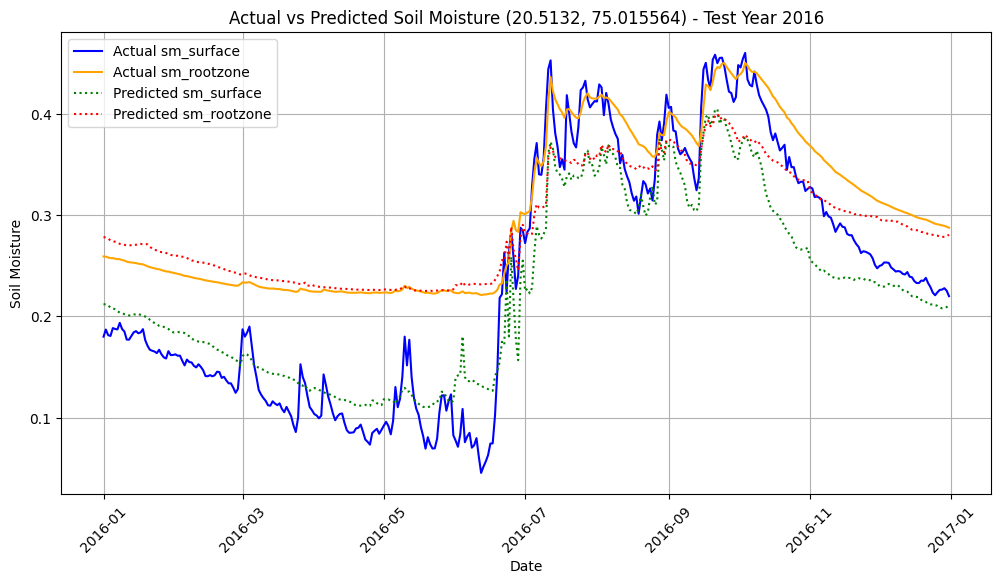

Loaded model: RF_SMAP_20.5132_75.015564_test2017.joblib


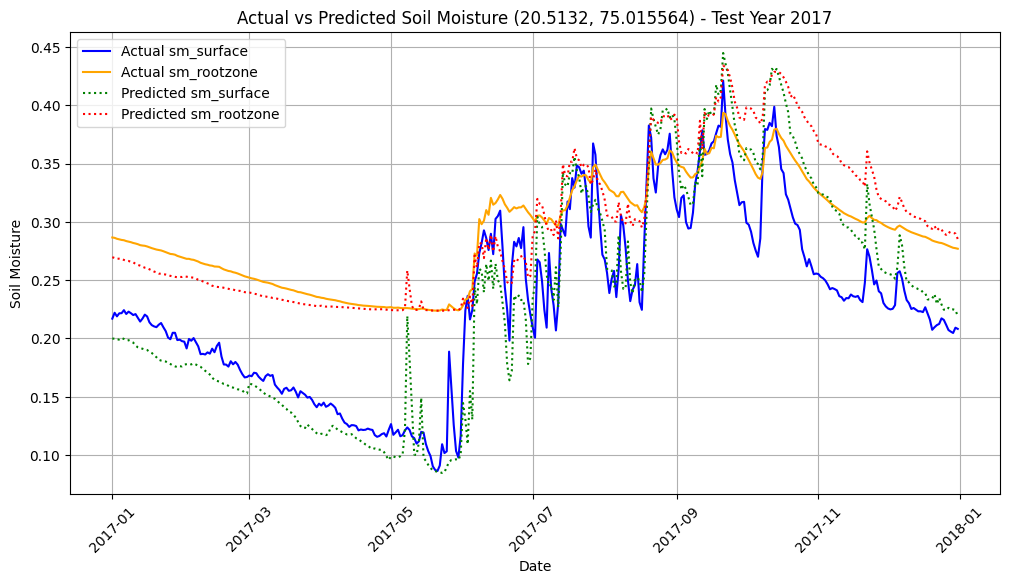

Loaded model: RF_SMAP_20.5132_75.015564_test2018.joblib


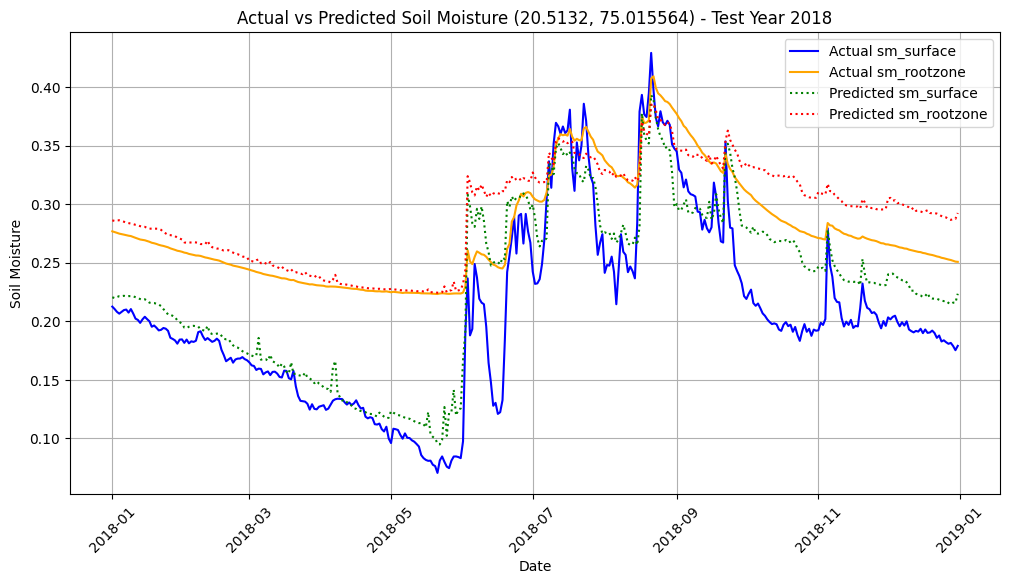

Loaded model: RF_SMAP_20.5132_75.015564_test2019.joblib


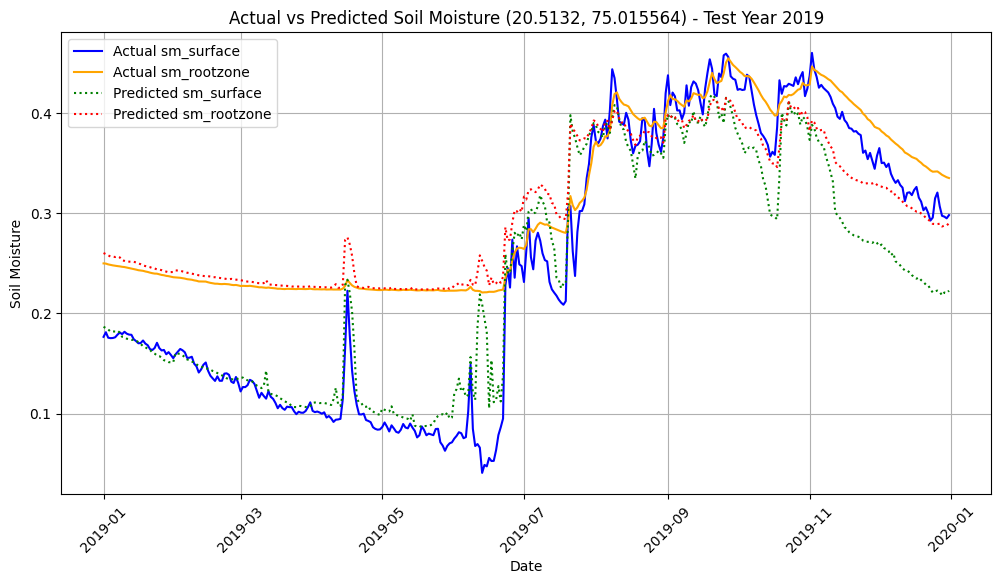

Loaded model: RF_SMAP_20.5132_75.015564_test2020.joblib


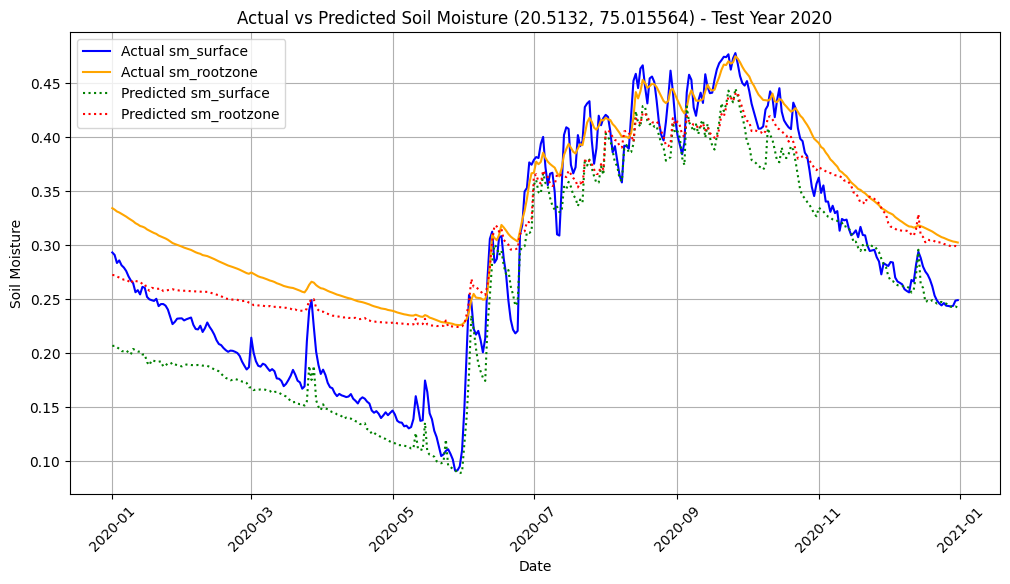

In [35]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the latitude and longitude of interest
selected_lat = 20.5132  # Change as per requirement
selected_lon = 75.015564  # Change as per requirement

# File and model paths
folder_path = r"B:\ml modeling project course\lessfiles"
model_output_dir = r"B:\ml modeling project course\trained_models"

# Find the corresponding CSV file
csv_filename = f"SMAP_{selected_lat}_{selected_lon}.csv"  # Modify based on your filename pattern
csv_filepath = os.path.join(folder_path, csv_filename)

# Check if file exists
if not os.path.exists(csv_filepath):
    print(f"File {csv_filename} not found!")
else:
    # Read the CSV file
    df = pd.read_csv(csv_filepath)
    
    # Feature Engineering
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Latitude'] = selected_lat
    df['Longitude'] = selected_lon
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Get unique years
    years = sorted(df['Year'].unique())

    # Features and targets
    features = ["Year", "Month", "Day", "Latitude", "Longitude", "sm_surface_model", "sm_rootzone_model"]
    targets = ["sm_surface", "sm_rootzone"]

    # Define color map for test years
    colors = plt.cm.get_cmap("tab10", len(years))

    for i, test_year in enumerate(years):
        # Load the corresponding trained model
        model_filename = f"RF_SMAP_{selected_lat}_{selected_lon}_test{test_year}.joblib"
        model_path = os.path.join(model_output_dir, model_filename)

        if os.path.exists(model_path):
            model = joblib.load(model_path)
            print(f"Loaded model: {model_filename}")

            # Define test mask
            test_mask = df['Year'] == test_year
            X_test = df.loc[test_mask, features]
            y_test = df.loc[test_mask, targets]

            # Make predictions
            preds = model.predict(X_test)

            # Choose a unique color for each year
            color = colors(i)

            # Create a time series plot
            plt.figure(figsize=(12, 6))

            # Plot actual values
            plt.plot(df.loc[test_mask, 'Date'], y_test['sm_surface'], label="Actual sm_surface", linestyle='solid', color="blue")
            plt.plot(df.loc[test_mask, 'Date'], y_test['sm_rootzone'], label="Actual sm_rootzone", linestyle='solid', color="orange")

            # Plot predicted values
            plt.plot(df.loc[test_mask, 'Date'], preds[:, 0], label="Predicted sm_surface", linestyle='dotted', color="green")
            plt.plot(df.loc[test_mask, 'Date'], preds[:, 1], label="Predicted sm_rootzone", linestyle='dotted', color="red")

            # Formatting the plot
            plt.xlabel("Date")
            plt.ylabel("Soil Moisture")
            plt.title(f"Actual vs Predicted Soil Moisture ({selected_lat}, {selected_lon}) - Test Year {test_year}")
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid()
            plt.show()

        else:
            print(f"Model for test year {test_year} not found, skipping.")


In [38]:
import pandas as pd
import numpy as np

# Load data from CSV
input_filename = r"B:\ml modeling project course\filtered_lalo\SMAP_21.95001_75.015564.csv"  # Change this to your actual file
output_filename = "random_date_groups.csv"

df = pd.read_csv(input_filename)

# Shuffle dates randomly
np.random.seed(42)  # For reproducibility
shuffled_dates = df["Date"].sample(frac=1, random_state=42).values

# Split into 5 equal-sized groups
num_groups = 5
grouped_dates = np.array_split(shuffled_dates, num_groups)

# Find the maximum group size to ensure all columns have equal length
max_len = max(len(g) for g in grouped_dates)

# Pad shorter groups with NaN to match lengths
padded_groups = {
    f"Group_{i+1}": np.pad(g.astype(object), (0, max_len - len(g)), constant_values=np.nan) 
    for i, g in enumerate(grouped_dates)
}

# Create a DataFrame
grouped_df = pd.DataFrame(padded_groups)

# Save as CSV
grouped_df.to_csv(output_filename, index=False)

print(f"Randomized date groups saved to {output_filename}")

Randomized date groups saved to random_date_groups.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Directories ---
folder_path = r"B:\ml modeling project course\lessfiles"  # Input CSV files
folder_pathout = r"B:\ml modeling project course"  # Output directory
model_output_dir = os.path.join(folder_pathout, "trained_models_group")  # Model storage
os.makedirs(model_output_dir, exist_ok=True)

# Load group dates
groups_csv_path = r"B:\ml modeling project course\random_date_groups.csv"  # Groups CSV file
groups_df = pd.read_csv(groups_csv_path)

# Convert group dates to dictionary {Group1: [date1, date2], Group2: [date1, date2]...}
group_dates = {
    group: pd.to_datetime(groups_df[group].dropna().astype(int).astype(str), format='%Y%m%d').tolist()
    for group in groups_df.columns
}

# Features & Targets
features = ["Year", "Month", "Day", "Latitude", "Longitude", "sm_surface_model", "sm_rootzone_model"]
targets = ["sm_surface", "sm_rootzone"]

# --- Train Random Forest Models ---
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        base_name = os.path.splitext(file)[0]  # Extract filename without extension
        
        try:
            lat, lon = map(float, base_name.split('_')[1:3])  # Extract lat, lon from filename
        except (ValueError, IndexError):
            print(f"Skipping {file}: Invalid filename format")
            continue
        
        df = pd.read_csv(os.path.join(folder_path, file))
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')  # Convert date
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['Latitude'] = lat
        df['Longitude'] = lon
        df = df.sort_values('Date').reset_index(drop=True)

        print(f"\nProcessing {file}")

        # Train model for each test group
        for group_name, test_dates in group_dates.items():
            test_mask = df['Date'].isin(test_dates)
            train_mask = ~test_mask  # Train on non-test dates

            if test_mask.sum() == 0 or train_mask.sum() == 0:
                print(f"Skipping {group_name}: Insufficient samples")
                continue
            
            X_train, X_test = df.loc[train_mask, features], df.loc[test_mask, features]
            y_train, y_test = df.loc[train_mask, targets], df.loc[test_mask, targets]

            # Train Random Forest Model
            model = RandomForestRegressor(
                n_estimators=500,
                max_depth=20,
                max_features="sqrt",
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            ).fit(X_train, y_train)

            # Save Model
            model_filename = f"RF_{base_name}_{group_name}.joblib"
            joblib.dump(model, os.path.join(model_output_dir, model_filename))
            print(f"Saved {model_filename}")




Processing SMAP_20.5132_75.015564.csv
✅ Saved RF_SMAP_20.5132_75.015564_Group_1.joblib
✅ Saved RF_SMAP_20.5132_75.015564_Group_2.joblib
✅ Saved RF_SMAP_20.5132_75.015564_Group_3.joblib
✅ Saved RF_SMAP_20.5132_75.015564_Group_4.joblib
✅ Saved RF_SMAP_20.5132_75.015564_Group_5.joblib

Processing SMAP_20.5132_75.108925.csv
✅ Saved RF_SMAP_20.5132_75.108925_Group_1.joblib
✅ Saved RF_SMAP_20.5132_75.108925_Group_2.joblib
✅ Saved RF_SMAP_20.5132_75.108925_Group_3.joblib
✅ Saved RF_SMAP_20.5132_75.108925_Group_4.joblib
✅ Saved RF_SMAP_20.5132_75.108925_Group_5.joblib

Processing SMAP_20.5132_75.202286.csv
✅ Saved RF_SMAP_20.5132_75.202286_Group_1.joblib
✅ Saved RF_SMAP_20.5132_75.202286_Group_2.joblib
✅ Saved RF_SMAP_20.5132_75.202286_Group_3.joblib
✅ Saved RF_SMAP_20.5132_75.202286_Group_4.joblib
✅ Saved RF_SMAP_20.5132_75.202286_Group_5.joblib

Processing SMAP_20.5132_75.29565.csv
✅ Saved RF_SMAP_20.5132_75.29565_Group_1.joblib
✅ Saved RF_SMAP_20.5132_75.29565_Group_2.joblib
✅ Saved RF_SMA

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Evaluation Functions ---
def cal_r2(obs, pre):
    numerator = np.sum((obs - np.mean(obs)) * (pre - np.mean(pre)))
    denominator = np.sqrt(np.sum((obs - np.mean(obs)) ** 2) * np.sum((pre - np.mean(pre)) ** 2))
    return (numerator / denominator)**2

def cal_nse(obs, pre):
    numerator = np.sum((obs - pre) ** 2)
    denominator = np.sum((obs - np.mean(obs)) ** 2)
    return 1 - (numerator / denominator)

# --- Paths ---
model_output_dir = r"B:\ml modeling project course\trained_models_group"
folder_path = r"B:\ml modeling project course\lessfiles"
group_csv_path = r"B:\ml modeling project course\random_date_groups.csv"

# --- Load Group Dates ---
group_df = pd.read_csv(group_csv_path)
group_dates = {
    col: pd.to_datetime(group_df[col].dropna(), format="%Y%m%d")
    for col in group_df.columns
}

# --- Define Features and Targets ---
features = ["Year", "Month", "Day", "Latitude", "Longitude", "sm_surface_model", "sm_rootzone_model"]
targets = ["sm_surface", "sm_rootzone"]
results = []

# --- Model Evaluation Loop ---
for model_file in os.listdir(model_output_dir):
    if not model_file.endswith('.joblib'):
        continue

    model_path = os.path.join(model_output_dir, model_file)

    try:
        parts = model_file.replace(".joblib", "").split('_')
        lat, lon = parts[2], parts[3]
        base_name = f"{lat}_{lon}"
        group_name = "_".join(parts[-2:])  # e.g. Group_4
    except IndexError:
        print(f"Skipping {model_file}: Invalid filename format")
        continue

    # Load corresponding SMAP CSV data
    data_file = os.path.join(folder_path, f"SMAP_{base_name}.csv")
    if not os.path.exists(data_file):
        print(f"Skipping {model_file}: Data file not found")
        continue

    df = pd.read_csv(data_file)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

    # Add derived features used by model
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Latitude'] = float(lat)
    df['Longitude'] = float(lon)

    # Filter data based on test dates for the group
    test_dates = group_dates.get(group_name, [])
    if len(test_dates) == 0:
        print(f"Skip
              ping {model_file}: No test dates found for group {group_name}")
        continue

    test_mask = df['Date'].isin(test_dates)
    if test_mask.sum() == 0:
        print(f"Skipping {model_file}: No matching test samples found in dataset.")
        continue

    X_test = df.loc[test_mask, features]
    y_test = df.loc[test_mask, targets]

    # Load model and predict
    try:
        model = joblib.load(model_path)
    except Exception as e:
        print(f"Skipping {model_file}: Failed to load model — {e}")
        continue

    y_pred = model.predict(X_test)

    # Compute metrics
    metrics = {
        "Model": model_file,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": cal_r2(y_test.values.flatten(), y_pred.flatten()),
        "NSE": cal_nse(y_test.values.flatten(), y_pred.flatten()),
    }
    results.append(metrics)

# --- Save Results ---
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(model_output_dir, "model_randomsplit_results.csv"), index=False)
print("\nModel evaluation completed! Results saved to model_randomsplit_results.csv")



✅ Model evaluation completed! Results saved to model_evaluation.csv


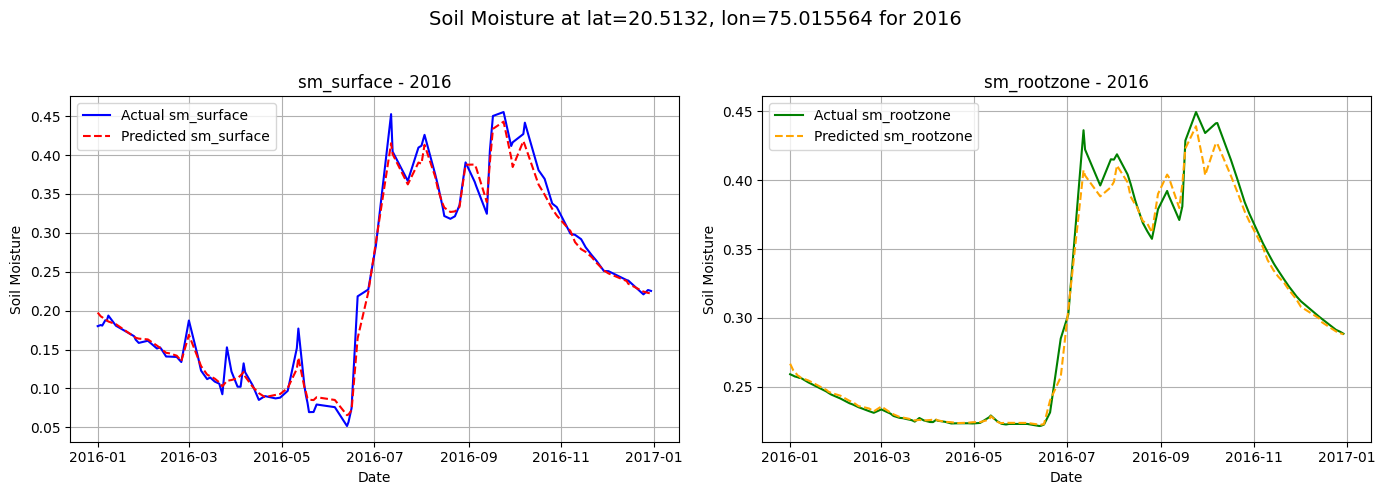

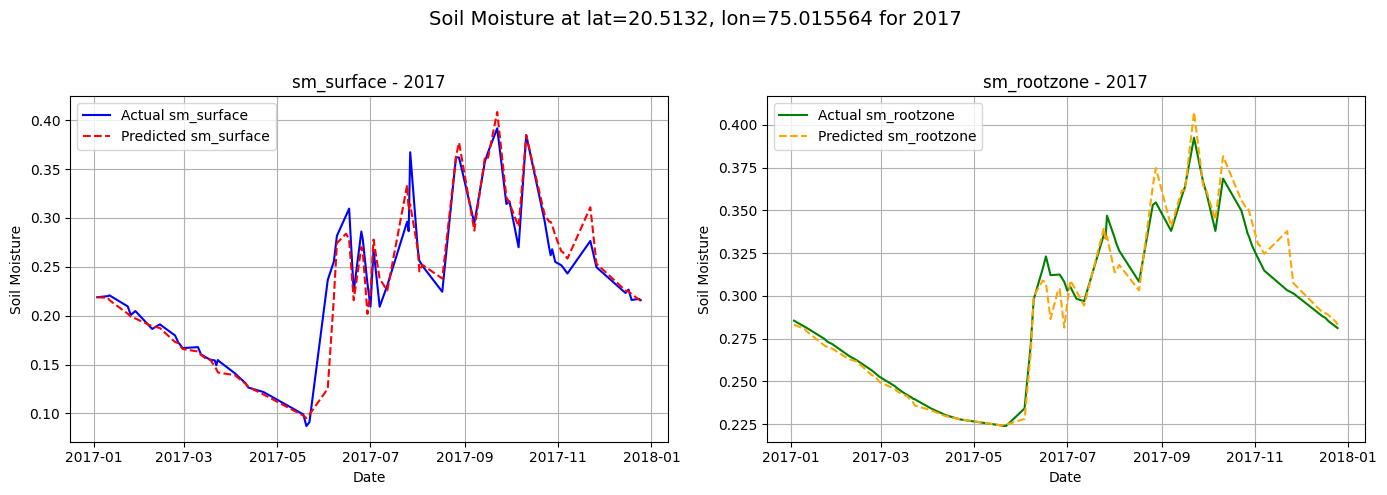

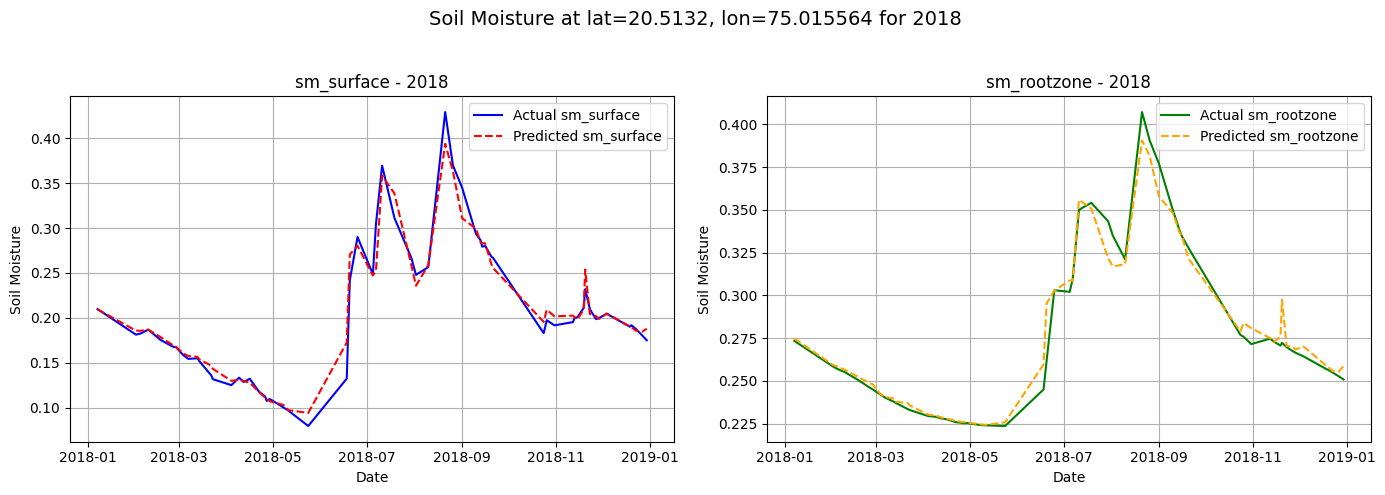

In [8]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# --- Settings ---
lat = 20.5132  # Change as per requirement
lon = 75.015564  # Change as per requirement
group_name = "Group_3"
model_dir = r"B:\ml modeling project course\trained_models_group"
data_dir = r"B:\ml modeling project course\lessfiles"
group_csv = r"B:\ml modeling project course\random_date_groups.csv"

# --- Load Group Dates ---
group_df = pd.read_csv(group_csv)
test_dates = pd.to_datetime(group_df[group_name].dropna(), format="%Y%m%d")

# --- Format File Names ---
base_name = f"{lat}_{lon}"
model_filename = f"model_{lat}_{lon}_{group_name}.joblib"
data_filename = f"SMAP_{base_name}.csv"

model_path = os.path.join(model_dir, model_filename)
data_path = os.path.join(data_dir, data_filename)

# --- Load Model ---
model = joblib.load(r"B:\ml modeling project course\trained_models_group\RF_SMAP_20.5132_75.015564_Group_3.joblib")

# --- Load and Prepare Data ---
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Latitude'] = lat
df['Longitude'] = lon

# Filter only test dates
df = df[df['Date'].isin(test_dates)].copy()

# Predict
features = ["Year", "Month", "Day", "Latitude", "Longitude", "sm_surface_model", "sm_rootzone_model"]
targets = ["sm_surface", "sm_rootzone"]

X = df[features]
y_true = df[targets]
y_pred = model.predict(X)

df['sm_surface_pred'] = y_pred[:, 0]
df['sm_rootzone_pred'] = y_pred[:, 1]

# --- Plotting (for 3 years) ---
years_to_plot = sorted(df['Year'].unique())[:3]  # Pick first 3 years

for year in years_to_plot:
    df_year = df[df['Year'] == year]
    
    plt.figure(figsize=(14, 5))
    
    # sm_surface
    plt.subplot(1, 2, 1)
    plt.plot(df_year['Date'], df_year['sm_surface'], label='Actual sm_surface', color='blue')
    plt.plot(df_year['Date'], df_year['sm_surface_pred'], label='Predicted sm_surface', color='red', linestyle='--')
    plt.title(f'sm_surface - {year}')
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.legend()
    plt.grid(True)

    # sm_rootzone
    plt.subplot(1, 2, 2)
    plt.plot(df_year['Date'], df_year['sm_rootzone'], label='Actual sm_rootzone', color='green')
    plt.plot(df_year['Date'], df_year['sm_rootzone_pred'], label='Predicted sm_rootzone', color='orange', linestyle='--')
    plt.title(f'sm_rootzone - {year}')
    plt.xlabel("Date")
    plt.ylabel("Soil Moisture")
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Soil Moisture at lat={lat}, lon={lon} for {year}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
